# Inspired from: https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb 

In [1]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 29.2 MB/s 
     |████████████████████████████████| 120 kB 63.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 32.2 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 6.6 MB 52.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 34.2 MB/s 


In [2]:
gvidia-smi

Tue Sep 20 19:59:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [7]:
# make sure you're logged in with `huggingface-cli login`
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

0it [00:00, ?it/s]

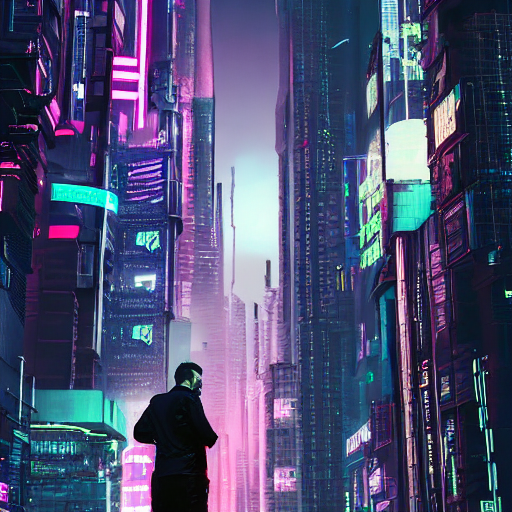

In [14]:
prompt = 'a man looking cyberpunk city'
with autocast(device):
  image = pipe(prompt)['sample'][0]
image

In [15]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

0it [00:00, ?it/s]

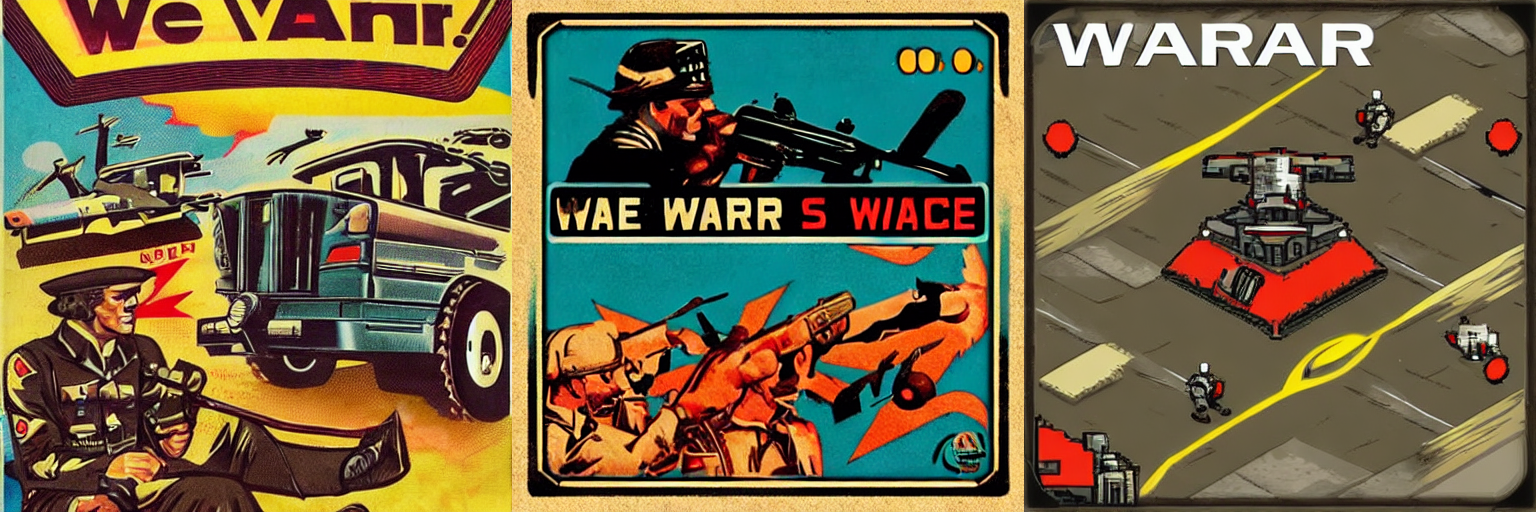

In [20]:
n_images = 3
prompts = ['retro war'] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=100)['sample']
image_grid(images, rows=1, cols=3)

In [ ]:
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)
# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.6.mlp.fc1.bias', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.post_layernorm.weight', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.4.self_attn.k_proj.bias', 'vision_model.encoder.layers.2.mlp.fc2.weight', 'vision_model.encoder.layers.8.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.mlp.fc1.weight', 'text_projection.weight', 'vision_model.encoder.layers.15.self_attn.v_proj.weight', 'vision_model.encoder.layers.5.layer_norm2.bias', 'vision_model.encoder.layers.19.layer_norm1.bias', 'vision_model.encoder.laye

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
def get_text_embeds(prompt):
  text_input = tokenizer(
      prompt, padding='max_length', max_length=tokenizer.model_max_length,
      truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
  uncond_input = tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

def produce_latents(text_embeddings, height=512, width=512,num_inference_steps=50, guidance_scale=7.5, latents=None):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels,height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']

  return latents

In [ ]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents
  with torch.no_grad():
    imgs = vae.decode(latents)
  imgs = (imgs / 2 + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Image.fromarray(image) for image in imgs]
  return pil_images

In [ ]:
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None):
  if isinstance(prompts, str):
    prompts = [prompts]
  text_embeds = get_text_embeds(prompts)
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)
  imgs = decode_img_latents(latents)

  return imgs

0it [00:00, ?it/s]

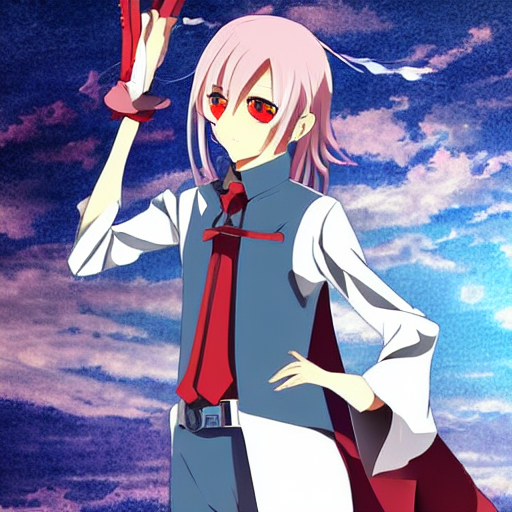

In [ ]:
prompt_to_img('Super cool anime character', 512, 512, 20)[0]

In [ ]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None,
                    return_all_latents=False):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  latent_hist = [latents]
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):

      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']
      latent_hist.append(latents)
  
  if not return_all_latents:
    return latents

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents

def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,guidance_scale=7.5, latents=None, return_all_latents=False,batch_size=2):
  if isinstance(prompts, str):
    prompts = [prompts]
  text_embeds = get_text_embeds(prompts)
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
      return_all_latents=return_all_latents)
  all_imgs = []
  for i in tqdm(range(0, len(latents), batch_size)):
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

In [ ]:
prompt = 'Starry night with a violet sky digital art'
video_frames = prompt_to_img(
    prompt, num_inference_steps=40, return_all_latents=True)

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
def imgs_to_video(imgs, video_name='video.mp4', fps=15):
  video_dims = (imgs[0].width, imgs[0].height)
  fourcc = cv2.VideoWriter_fourcc(*'DIVX')    
  video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
  for img in imgs:
    tmp_img = img.copy()
    video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
  video.release()

def display_video(file_path, width=512):
  compressed_vid_path = 'comp_' + file_path
  if os.path.exists(compressed_vid_path):
    os.remove(compressed_vid_path)
  os.system(f'ffmpeg -i {file_path} -vcodec libx264 {compressed_vid_path}')

  mp4 = open(compressed_vid_path, 'rb').read()
  data_url = 'data:simul2/mp4;base64,' + b64encode(mp4).decode()
  return HTML("""
    <video width={} controls>
          <source src="{}" type="video/mp4">
    </video>
    """.format(width, data_url))

In [ ]:
vid_name = prompt.replace(' ', '_') + '.mp4'
imgs_to_video(video_frames, vid_name)
display_video(vid_name)